# **Classical RL**: Single Agent in a Grid World

The topics in this notebook are basically the ones convered in [Sutton & Barto's seminal book](http://incompleteideas.net/book/RLbook2020.pdf).

# An Extremely Brief Introduction to Classical RL

Common to all Reinforcement Learning problems is the existence of an agent in a dynamic system having to pick an action $a_t$ when it finds itself in a state $s_t$ with the goal of optimizing an accumulation of future rewards, also called value. In chess, for instance, $a_t$ would be your next move, $s_t$ is the current chess board and the value is some measure of how 'good' the position is for you.

The goal of RL, then, is to build some mapping $\pi : \mathcal{S} \rightarrow \mathcal{A}$ that is able to generate actions that will yield a big expected long-term value for the agent, even at the cost of smaller immediate rewards (e.g. sacrificing a piece in chess). 

This mapping $\pi$ is called a **policy**.

## 1 - Optimal Policy, $\pi^{\star}$

Given a state $s$, the 'quality' of policy $\bar\pi$ is measured by the expected value the agent will get from it:
- $V_{\bar \pi}(s) = \mathbb{E}_{a_t = \bar \pi(s_t), \; s_{t+1} \sim \mathcal{T}(s_t,a_t)}[\sum_{t=0}^T \gamma^t R(s_t, a_t) | s_0=s]$.

A policy $\pi^{\star}$ is said to be optimal if $V_{\pi^{\star}}(s) \geq V_{\pi}(s), \forall \pi, s$. It means all other policies yield an expected value that is either equal to or smaller than $\pi^{\star}$ in every single state. In this case, we define $V_{\star} := V_{\pi^{\star}}$. 


## 2- How to find $\pi^{\star}$?

The ultimate goal of RL is to find an optimal policy for a given problem. 

As we will see in this notebook, there are many ways to approach this, though in most interesting problems only 'good enough' suboptimal policies can be found.

### 2.1 - Extract $\pi^{\star}$ from $V^{\star}$

In some problems, it is possible to find $V^{\star}(s), \forall s$ and then build $\pi^{\star}$ from it by chosing the action $a_t$ that will take the agent from $s_t$ to $s_{t+1} = \text{argmax} \left( R(s,a) + V^{\star}(s') \right)$. That is, we will pick an action that can take the agent to the next state with highest possible optimal value (i.e. the most convient next state). 

From the definition above, note that an algorithm can only extract $\pi^{\star}$ from $V^{\star}$ if it is able to simulate the system dynamics, given by $s_{t+1} \sim \mathcal{T}(s_t,a), \forall a$. Although this is true for some systems, it is certainly not true for many.

Finding $V^{\star}$ is generally impossible, even with full knowledge of the system dynamics. So we will almost always rely on some approximation $\hat V \approx V^{\star}$.


### 2.2 -  Extract $\pi^{\star}$ from $Q^{\star}$

As mentioned in 2.2.1, if we do not know anything about the system dynamics, it's not possible to extract $\pi^{\star}$ from $V^{\star}$. We can, however, use a better suited measure for the quality of choosing $(s,a)$ instead of just $s$, and then following $a_{t} = \pi_{t}(s_{t})$.

This measure, $Q$, is called a state-action value:

- $Q_{\bar \pi}(s,a) = \mathbb{E}_{a_t = \bar \pi(s_t),  \; s_{t+1} \sim \mathcal{T}(s_t,a_t)}[R(s,a) + \sum_{t=1}^T \gamma^t R(s_t, a_t) | s_0 = s]$

If we can find $Q^{\star}$, that is, how convenient it is to perform $a$ in $s$ and then follow an optimal policy, then we can easily extract $\pi^{\star}$ by finding:

$$
    \pi^{\star}(s) = \underset{a \in \mathcal{A}}{\text{argmax}} \left( Q^*(s,a) \right)
$$

As is the case of $V^{\star}$, it is generally impossible to find $Q^{\star}$. So we will almost always rely on some approximation $\hat Q \approx Q^{\star}$.

### 2.3 - Find $\pi^{\star}$ from some random $\pi_0$

Other methods involve starting off with some random policy $\pi_0$ and using an interative process to generate $\pi_0 \rightarrow \pi_1 \rightarrow \pi_2 \rightarrow ...$ such that $V_{\pi_{k+1}}(s) \geq V_{\pi_k}(s)$ , $\forall k,s$. That is, a process that generates better and better policies.

## 3 - Learning v. Planning

As mentioned in the last section, some approaches assume some knowledge about the system dynamics, while others don't assume any knowledge at all. The first case is called **Planning**, while the second is called **Learning**.

Let's take a maze-solving agent as an example:
- **Planning**: Allows the agent to simulate how close it would be to the exit by  choosing directions $a_0a_1...a_n$ before taking any step in real life. Solving this becomes, then, a Dynamic Programming task (e.g. a tree search of action $\rightarrow$ states $\rightarrow$ action $\rightarrow$ ...). The biggest restriction here is the sheer size of the state-space, which often makes an optimal solution impossible to be obtained.

- **Learning**: Requires the agent to take action $a_0$ and observing state $s_1$ in real life. By trial-and-error, the agent will learn from experience how convenient it is to perform $a_t$ while in $s_t$, as no model or simulator is provided.

The interplay between Planning and Learning happens a lot in Reinforcement Learning, and the difference can be blurry. Some models, like DynaQ, uses both methods to learn an optimal action-value function $Q^*$.


---
# **Practical Example**: Single Agent in a Grid World

In this notebook, we will analyze a very simple game. It consists of a grid where a single agent (blue) can move either up, down, left or right at every turn, in search for a prize (green). 

<center><img src="game_example.png" heigh=600, width=400> </center>


The prize (green) is unique and the game is over (with a big reward) if the agent reaches it.

In the grid, there are also barriers (black), which block the agents movement, as if it is hitting a wall. Finally, there are also bombs (red), which kill the agent if he reaches it. 

Thus, the game ends if one of the following happens:
- the agent has played for a predefined $T$ steps
- the agent reaches the prize
- the agent reaches a bomb

For simplicity, we'll only consider the deterministic case.

# 1. Game Setup

In this section, we will build the grid and place the prize, the agent's initial position, the bombs and the barriers randomly in it. We will also build the game's dynamics (i.e. changing the grid as actions are taken).

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from IPython.display import clear_output
import time

np.random.seed(31)
np.set_printoptions(formatter={'float': '{:10f}'.format})

## 1.1 - The Grid

The grid will start off as a ```grid_shape[0]``` by ```grid_shape[1]``` matrix of zeros.

In [9]:
# Grid Shape
grid_shape = [10, 10]

# Creating grid
grid = np.zeros(grid_shape).astype(int)
print(grid)

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


## 1.2 - The Prize



We'll then insert a prize in a random location on the grid.

Its symbol will be ```symbol_prize```.

The reward for collecting it will be ```reward_prize```.

In [10]:
# Reward of the prize
reward_prize = 10

# Symbol for the prize in the grid
symbol_prize = reward_prize

# Getting all empty indexes from the grid: [[0,0], [0,1], ...]
empty_indexes = np.stack(np.where(grid == 0)).T

# Sampling 1 empty index from empty_indexes 
random_i = np.random.choice(range(empty_indexes.shape[0]), 1)[0]
prize_idx = empty_indexes[random_i,:]

# Adding prizes to grid with label 'reward_prize'
grid[*prize_idx] = symbol_prize
print(grid)

[[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]


## 1.3 - The Barriers

We'll then insert ```n_barriers``` barriers in random non-empty location on the grid.

Its symbol will be ```symbol_barrier```.

In [11]:
# Number of bombs
n_barriers = 10

# Symbol for the bomb on the grid
symbol_barrier = -1

# Getting all empty indexes from the grid: [[0,0], [0,1], ...]
empty_indexes = np.stack(np.where(grid == 0)).T

# Sampling 'n_barriers' empty indexes for our prize locations
random_i = np.random.choice(range(empty_indexes.shape[0]), n_barriers, replace=False)
barrier_idxs = empty_indexes[random_i,:]

# Adding bombs to grid with label 'reward_bomb'
for idx in barrier_idxs:
    grid[*idx] = symbol_barrier
    
print(grid)

[[-1  0  0 -1  0  0  0  0 -1  0]
 [ 0  0  0  0  0  0  0 -1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 -1  0  0  0 -1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 -1  0  0  0]
 [-1  0  0  0  0  0  0 -1  0  0]
 [ 0  0  0  0  0  0 -1  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]


## 1.4 - The Bombs

We'll then insert ```n_bombs``` bombs in random non-empty location on the grid.

Its symbol will be ```symbol_bomb```.

In [12]:
# Number of bombs
n_bombs = 10

# Symbol for the bomb on the grid
reward_bomb = -10
symbol_bomb = reward_bomb

# Getting all empty indexes from the grid: [[0,0], [0,1], ...]
empty_indexes = np.stack(np.where(grid == 0)).T

# Sampling 'n_bombs' empty indexes for our prize locations
random_i = np.random.choice(range(empty_indexes.shape[0]), n_bombs, replace=False)
bomb_idxs = empty_indexes[random_i,:]

# Adding bombs to grid with label 'reward_bomb'
for idx in bomb_idxs:
    grid[*idx] = symbol_bomb
    
print(grid)

[[ -1   0   0  -1   0   0   0   0  -1   0]
 [-10 -10   0   0   0   0   0  -1   0   0]
 [  0   0   0   0   0   0 -10   0 -10   0]
 [-10   0   0  -1   0   0   0  -1   0   0]
 [  0   0   0 -10   0   0   0   0   0   0]
 [  0   0   0   0   0   0  -1   0   0   0]
 [ -1   0   0 -10   0   0   0  -1   0   0]
 [  0   0   0   0   0   0  -1   0   0   0]
 [-10   0  10   0   0 -10   0   0   0   0]
 [  0   0 -10   0   0   0   0   0   0   0]]


## 1.4 - The Agent

We'll then insert an agent in a random location on the grid.

It will be identified with ```symbol_agent```.

In [13]:
# The symbol for the agents on the grid, which should be different from all other
symbol_agent = max(symbol_prize, symbol_barrier, symbol_bomb) + 1

# Getting all empty indexes from the grid: [[0,0], [0,1], ...]
empty_indexes = np.stack(np.where(grid == 0)).T

# Sampling 1 empty index for our agent location
random_i = np.random.choice(range(empty_indexes.shape[0]), 1, replace=False)[0]
agent_idx = empty_indexes[random_i,:]

# Adding agent to grid with label ''
grid[*agent_idx] = symbol_agent

print(f'Agent symbol: {symbol_agent}\n')
print(grid)

Agent symbol: 11

[[ -1   0   0  -1   0   0   0   0  -1   0]
 [-10 -10   0   0   0   0   0  -1   0   0]
 [  0   0   0   0   0   0 -10   0 -10   0]
 [-10   0   0  -1   0   0   0  -1   0   0]
 [  0   0   0 -10   0   0   0   0   0   0]
 [  0   0   0   0   0   0  -1   0   0   0]
 [ -1   0   0 -10   0   0   0  -1   0   0]
 [  0   0   0   0   0   0  -1   0  11   0]
 [-10   0  10   0   0 -10   0   0   0   0]
 [  0   0 -10   0   0   0   0   0   0   0]]


## 1.6 - Plotting

In [14]:
# Getting the agent's [x,y] coordinates
def get_agent_pos(grid):
    return np.hstack(np.where(grid == symbol_agent))

In [15]:
# Function that plots the grid
def plot_game(grid, rewards=[0]):

    # Defining colors for each symbol
    colors = {
        0: 'white',
        symbol_prize: 'green',
        symbol_barrier: 'black',
        symbol_bomb: 'red',
        symbol_agent: 'blue'
    }

    clear_output(wait=True)

    # Convert the matrix values to a list of colors
    unique_values = list(colors.keys())  # Extract unique values in the correct order
    
    color_list = [colors[val] for val in unique_values]  # Generate a list of colors in the order of unique values
    # Create a ListedColormap using the colors
    cmap = ListedColormap(color_list)
    
    # Create an index map to translate values in the matrix to their corresponding indices in the cmap
    index_map = np.vectorize(lambda x: unique_values.index(x))(grid)
    
    # Plot the matrix using imshow and the custom colormap
    plt.imshow(index_map, cmap=cmap)
    
    scoreboard = f'Rewards: {float(np.sum(rewards))}'
    plt.title(scoreboard)


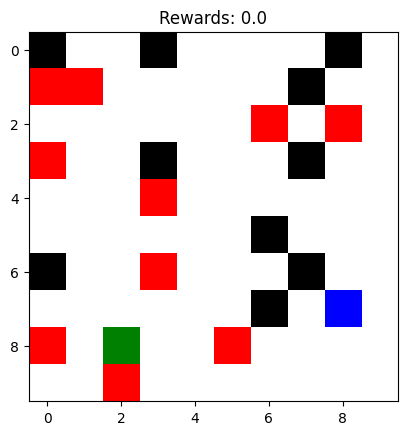

In [16]:
plot_game(grid)

In [17]:
# Saving the configartion as the initial state of the game
initial_grid = grid.copy()

## 1.7 - Dynamics

Below is a dicitionary with the allowed movements and their displacement effect on the agent's position.

In [18]:
# Allowed movements
MOVEMENTS = {
    'left': np.array([0,-1]), 
    'down':np.array([1,0]), 
    'right':np.array([0,1]), 
    'up':np.array([-1,0])
}

ACTIONS = list(MOVEMENTS.keys())
ACTIONS

['left', 'down', 'right', 'up']

In [19]:
# Reward for each time step
reward_timestep = -1

The function ```move``` outputs the new grid configuration after an ```action``` has been performed when in current grid configuration ```grid```. 

- If such action takes the agent to an empty cell, then the operation is simply removing the agent symbol from the old cell in the grid, and moving it to the new one.

- If such action takes the agent to a barrier or the border of the matrix, then it return the old configuration.

- If such action takes the agent to a bomb or a prize, then it return the final configuration with output ```terminate``` equal to True.

In [20]:
def move(action, grid):
    
    # We copy the grid so that our changes dont reflect on the grid
    grid = grid.copy()

    terminate = False
    
    reward = reward_timestep
    
    # If the action is not allowed (e.g. 'banana'), we raise an error
    if action not in MOVEMENTS.keys():
        raise ValueError(f'Possible movements are: { list(MOVEMENTS.keys()) }')
    
    # Otherwise, perform movement
    else:
        
        # Getting current position of the agent
        curr_pos = get_agent_pos(grid)
        
        # Getting the next position. 
        # Note that if the action would take the agent outside the grid, the agent stays in place.
        next_pos = curr_pos + MOVEMENTS[action]
        next_pos[0] = np.clip(next_pos[0], 0, grid_shape[0]-1)
        next_pos[1] = np.clip(next_pos[1], 0, grid_shape[1]-1)
        
        # We remove the agent from its current position
        grid[*curr_pos] = 0
        
        # If the next position is a prize...
        if grid[*next_pos] == symbol_prize:
            
            # Get prize reward
            reward = reward_prize

            terminate = True

        # If the next position is a prize...
        elif grid[*next_pos] == symbol_bomb:
            
            # Get prize reward
            reward = reward_bomb

            terminate = True
        
        # If the next position is a barrier...
        elif grid[*next_pos] == symbol_barrier:

            # Agent's position wont change
            next_pos = curr_pos
        
        # Place the agent in the next position
        grid[*next_pos] = symbol_agent
        
        return (grid, reward, terminate)

_Example: moving the agent to the right in one turn_

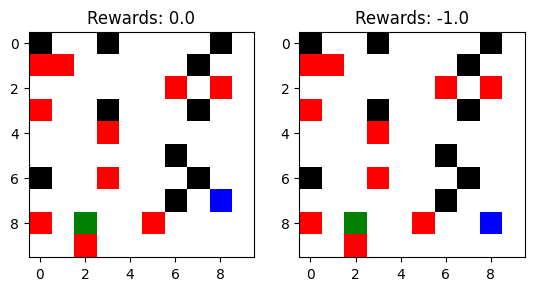

In [21]:
# Initial grid
plt.subplot(1,2,1)
plot_game(grid)

# Moving agent to down
(grid, reward, _) = move('down', grid)

# Plotting next grid
plt.subplot(1,2,2)
plot_game(grid, rewards=[reward])


The game as defined above is a Markov Decision Process (MDP) with:
- Action space $\mathcal{A} = \{ \text{left, right, up, down} \}$
  
- State space $\mathcal{S} = $ all possible grid configurations

- Reward function $R(s,a) = \begin{cases} \texttt{reward_prize}, & \text{if the agent reaches the prize when performing $a$ in $s$} \\ 
\texttt{reward_bomb}, & \text{if the agent reaches a bomb when performing $a$ in $s$}  \\ \texttt{reward_timestep}, & \text{otherwise} \end{cases}$

- Transition $\mathcal{T}$ as expected. For instance, the agents move to the left if $a$ = left and there is no barrier nor border to the left of it.

Note that since bombs and reward are terminal states, the number of possible grid configurations is just the number of cells in the grid minus the the number of cells that the agent cannot be in (i.e. barriers). This is essentially all the cells that the agent can be in:

$$
    |\mathcal{S}| = |\text{Grid}| - |\text{Barriers}|
$$

If we were to allow the bombs to just disappear (or randomly respawn) after the agent reaches it, and let it keep playing, then the number of states would be considerably larger. We would, for instance, need to consider one configuration where a bomb is in its initial position, and another where there is no bomb there as two distinct configurations, even if the agent is in the same cell in both cases.

Below, we will create a function that receives and applies ```policy``` for ```T``` steps.

In [22]:
def play(policy, T, wait=0.05, *args, **kwargs):

    # Starts with the initial grid
    grid = initial_grid

    # Starts with an empty reward array
    rewards = []
    
    for _ in range(T):
        
        # Picking action
        action = policy(grid, **kwargs)

        # Performing action
        (grid, reward, terminate) = move(action, grid)
        rewards.append(reward)

        plot_game(grid, rewards)
        plt.show()

        # Wait 'wait' seconds
        time.sleep(wait)

        # If there is no more prizes, the game ends
        if terminate:
            break
                
    return (rewards, terminate)

For all tests below, we will use the following value for ```T```:

In [23]:
T=100

# 2 - Planning

As explained in the first part, these algorithms rely on the ability to simulate actions before taking any steps in the real game.

## 2.1 - Myopic Algorithm

This is the most simple planning algorithm that exists. It simply simulates one step ahead for each available action $a \in \mathcal{A}$, observes and stores their reward and then performs the action that maximizes the immediate reward. That is, there is no long-term planning.

$$
    \pi(s) = \underset{a \in \mathcal{A}}{\text{argmax}} \left( R(s,a) \right)
$$

If $\text{argmax} \left( R(s,a) \right)$ is a set, then it just randomly samples one action from it.

This method is not optimal at all in general, but particularly so in cases with sparse reward (i.e. many steps with all one-step head actions resulting in 0 reward), like ours.

In [24]:
def myopic_policy(grid, **kwargs):

    # Simulated rewards for all possible actions
    sim_rewards = []

    # Simulating all actions
    for action in MOVEMENTS.keys():

        # Observes immediate reward
        # Note that this movement is not recorded in the 'real game'
        (_,r,_) = move(action, grid)

        # Stores immediate reward
        sim_rewards.append(r)

    # Transforming it into a numpy array
    sim_rewards = np.array(sim_rewards)

    # Finding actions that maximize the immediate reward
    argmax = np.argwhere(sim_rewards == sim_rewards.max()).T[0]

    # Picking a random action from the maximizers
    best_action = np.random.choice(argmax,1)[0]
    
    return ACTIONS[best_action]

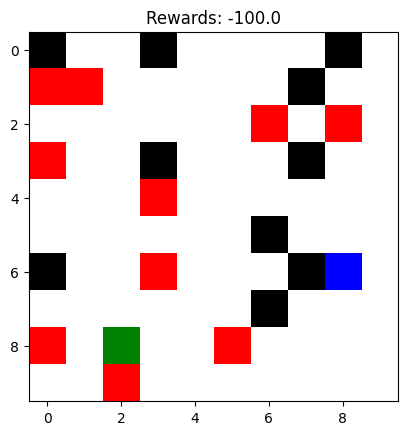

Reached terminal state?: False


In [25]:
(R_myopic, terminate) = play(myopic_policy, T)
print(f'Reached terminal state?: {terminate}')

## 2.2 - Next-Closest Policy

This policy picks the action that will the agent closest (Euclidean distance) to the prize.

It also simulates one-step ahead (like the Myopic Policy), but instead of relying on the game rewards, it 'builds' a new reward function with the knowledge from the prize's position. So, this policy assumes not only the ability to simulate actions, but also the knowledge about the prize's $(x,y)$ coordinates.

$$
\pi(s) = \underset{a \in \mathcal{A}}{\text{argmin}} \left( \; || \text{prize} - \text{agent}(a) ||_2 \; \right)
$$

Here, $ \text{agent}(a)$ is the next position of the agent after $a$ has been performed.

In [26]:
def nextclosest_policy(grid, **kwargs):

    # Get position of the prize
    prize_pos = np.stack(np.where(grid == reward_prize)).T

    # Simulated rewards for all possible actions
    next_distances = []

    # Simulating all actions
    for action in MOVEMENTS.keys():

        # Getting agent's position when 'action' is taken
        (next_grid,_,_) = move(action, grid)
        next_pos = get_agent_pos(next_grid)

        # Getting Euclidean distance from the agent's next position to the prize
        next_dist_to_prize = min(np.linalg.norm(prize_pos - next_pos, 2, axis=1))

        # Storing in 'next_distances' array
        next_distances.append(next_dist_to_prize)
        
    next_distances = np.array(next_distances)

    # Getting the action index with smallest distance
    best_action = np.argmin(next_distances)

    return ACTIONS[best_action]

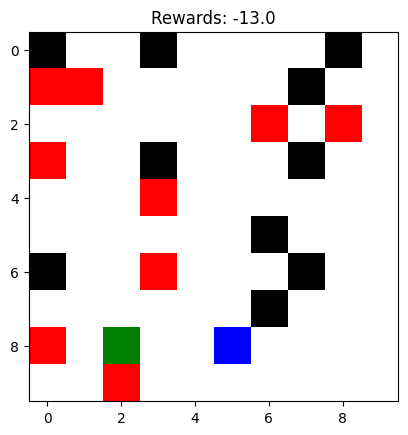

Reached terminal state?: True


In [27]:
(R_next, terminate) = play(nextclosest_policy, T)
print(f'Reached terminal state?: {terminate}')

## 2.1 - Value Iteration

Value Iteration works by initializing $V_0(s)=0, \forall s$, and then iteratively building $V_0 \rightarrow V_1 \rightarrow V_2 \rightarrow ...$, such that $V_k(s) \xrightarrow{k \rightarrow \infty} V^{\star}(s), \forall s$.

This iterative process here is the Bellman Operator, wherein for all $s \in \mathcal{S}$:

$$
    V_{k+1}(s) = \underset{a \in \mathcal{A}}{\max} \left( R(s,a) + V_k(s'_a) \right), \text{ where } (s,a) \rightarrow s'_a
$$

After iterating through big enough $k$, we'll have $V_{k} \approx V^{\star}$. 

Then, we can use the following policy to control the agent:

$$
    \pi(s) = \underset{a \in \mathcal{A}}{\text{argmax}} \left( R(s,a) + V_k(s'_a) \right)
$$

Let's start by building $V_k$:

In [28]:
# Creating a grid that is the initial grid, but without agents
template_state = initial_grid.copy()
template_state[template_state==symbol_agent] = 0

# Saving the indexes of all empty cells as states (agent can be in anyone of them)
states = np.stack(np.where(template_state == 0)).T

print(f'Number of states: {len(states)}')

Number of states: 79


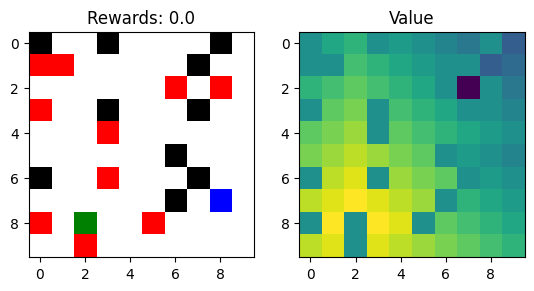

In [29]:
# Initializating values as 0
V = np.zeros(len(states))

# Setting number of iterations
N_iter = 20

# Running 'N_iter' iterations of Value Iteration
for _ in range(N_iter):

    # Creating a temporary vector that will replace V
    V_next = V.copy()

    # Iterating through all states
    for i, state in enumerate(states):

        # Build first grid configuration
        curr_grid = template_state.copy()
        curr_grid[*state] = symbol_agent

        # Vector that will save the value for each action
        V_actions = []
    
        for action in ACTIONS:

            # Perform action
            (next_grid, r, _) = move(action, curr_grid)

            # Getting index of the next state 
            next_agent_pos = get_agent_pos(next_grid)
            next_state = np.where((states == next_agent_pos).all(1))[0]

            # If next_state is not in the state (its a terminal state), set value as r only
            if len(next_state)==0:
                V_actions.append(r)

            # Else, set value as r + Value of next state
            else:
                V_actions.append(r + float(V[next_state][0]))

        # Saving max(V_actions) as the new iteration for the value function
        V_next[i] = np.max(V_actions)

    # Replacing old value function with new
    V = V_next.copy()

    # Plotting everything
    value_grid = np.zeros(grid.shape)
    for i, state in enumerate(states):
        value_grid[*state] = V[i]
    plt.subplot(1,2,1)
    plot_game(initial_grid)
    plt.subplot(1,2,2)
    plt.gca().cla()
    plt.imshow(value_grid)
    plt.title('Value')
    plt.show()
    time.sleep(0.05)
    
Value = value_grid

Now, let's build the policy extracted from $V_k$.

In [30]:
def v_iteration_policy(grid, **kwargs):
    
    # Simulated rewards for all possible actions
    sim_values = []

    # Simulating all actions
    for action in ACTIONS:

        # Observes immediate reward
        # Note that this movement is not recorded in the 'real game'
        (next_grid, r, _) = move(action, grid)
        next_pos = get_agent_pos(next_grid)

        # Stores immediate reward + Value of next state
        sim_values.append(r + Value[*next_pos])

    # Transforming it into a numpy array
    sim_values = np.array(sim_values)

    # Finding actions that maximize the immediate reward + V(next state)
    argmax = np.argwhere(sim_values == sim_values.max()).T[0]

    # Picking a random action from the maximizers
    best_action = np.random.choice(argmax,1)[0]
    
    return ACTIONS[best_action]

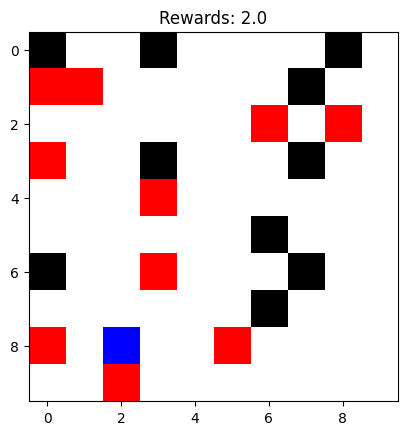

Reached terminal state?: True


In [31]:
(R_value, terminate) = play(v_iteration_policy, T, Value=Value)
print(f'Reached terminal state?: {terminate}')

# 3 - Model-Free Learning

These algorithms do not rely on any model or simulator for the system dynamics. It must learn from experience 

## 3.1 - Random Policy

Although this policy does not use knowledge from the system dynamics, it also learns nothing. It is the most simples model-free learning possible.

This policy picks a random action in each state: $\pi(s) \sim \mathcal{U}(\mathcal{A})$

In [32]:
def random_policy(grid, **kwargs):

    # Picks a random action from ACTIONS
    random_action = np.random.choice(ACTIONS,1)[0]
    
    return str(random_action)

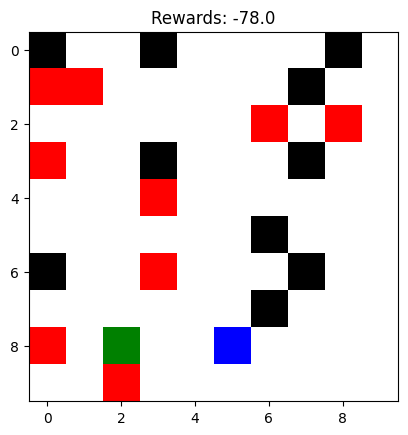

Reached terminal state?: True


In [33]:
(R_rand, terminate) = play(random_policy, T)
print(f'Reached terminal state?: {terminate}')

## 3.2 - [Q-Learning (Watkins et al)](https://link.springer.com/content/pdf/10.1007/BF00992698.pdf)

This method assumed no knowledge about the environment, but it does require the agent to play many times in the environment.

It first builds a matrix $\hat Q \in \mathbb{R}^{|S| \times |A|}$, such that $\hat Q(s,a)$ captures how good it is to perform $a$ when in state $s$.

Then, we just perform:

$$
\pi(s) = \underset{a \in \mathcal{A}}{\text{argmin}} \left( \hat Q(s,a) \right)
$$

The trick is learning how to build $\hat Q$ in the first place.

**Building $\hat Q$**

Starting with $\hat Q^{(0)}(s,a) = 0, \forall a,s$ and $s_0 \in \mathcal{S}$, we will perform for $t=1,2,...,N_{train}$:

- Perform 1 action:

$$
    a_{t-1} \sim \epsilon\text{-greedy} \left( \hat Q^{(t-1)}(s_{t-1},:) \right)
$$

$$
    s_t \sim \mathcal{P}(s_{t-1}, a_{t-1},:)
$$

$$
    r \sim R(s_{t-1}, a_{t-1})
$$

- Update $\hat Q$:
  
$$
    \hat Q^{(t)}(s_{t-1},a_{t-1}) \gets (1-\alpha) \hat Q^{(t-1)}(s_{t-1},a_{t-1}) + \alpha \left( r + \gamma \underset{a \in \mathcal{A}}{\text{argmax}} \left( \hat Q^{(t-1)}(s_t,a) \right) \right)
$$

It can be shown that $\hat Q^{(t)}(s,a) \xrightarrow{t \rightarrow \infty} Q^*(s,a), \forall s,a$

In [34]:
# Hyper-parameters
alpha = 0.5
N_train = int(2e4)
epsilon = 0.2
discount = 1

# Restarting grid
grid = initial_grid

# Initializing Q as zeros
Q = np.zeros([len(ACTIONS), grid_shape[0], grid_shape[1]])

for t in range(N_train):

        # S <- agent's current position
        S = get_agent_pos(grid)

        # Epsilon-Greedy over Q(s,a) to pick a
        if np.random.rand() < epsilon:
            action = random_policy(grid)
            action_idx = ACTIONS.index(action)
        else:
            action_idx = Q[:, S[0], S[1]].argmax().astype(int)
            action = ACTIONS[action_idx]

        # Perform action a, get next state and reward
        (grid, reward, _) = move(action, grid)
        S_next = get_agent_pos(grid)

        # Update Q
        Q[action_idx, S[0], S[1]] = (1-alpha)*Q[action_idx, S[0], S[1]] + alpha*(reward + discount*Q[:, S_next[0], S_next[1]].max())

        # If the state is terminal, start over
        if (~np.any(grid == reward_prize)):

            # Restarting grid
            grid = initial_grid
            

**Using $\hat Q$**

Now that we have $Q^{(N_{train})}(s,a)$, we can maximize over it as our policy: $ \pi(s) = \underset{a \in \mathcal{A}}{\text{argmin}} \left( \hat Q^{(N_{train})}(s,a) \right)$

In [35]:
def qlearning_policy(grid, **kwargs):

    # Get agent's current position
    S = get_agent_pos(grid)

    # Pick action that maximizes Q at S
    best_action = np.argmax(Q[:, *S])
    
    return ACTIONS[best_action]

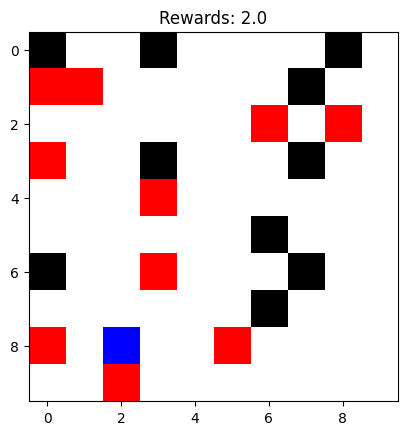

In [36]:
(R_Q, _) = play(qlearning_policy, T, Q=Q)

# 3 - Comparing Policies

We will now plot the value, $V_{s_0}^{(\pi)} = \sum_{t=1}^T R(s_t, a_t)$, where $s_0$ is given and $a_t = \pi(s_t)$ for policy $\pi$.

In most cases, Q-Learning will be the best performing policy out of the four, at least if ```N_train``` is big enough.

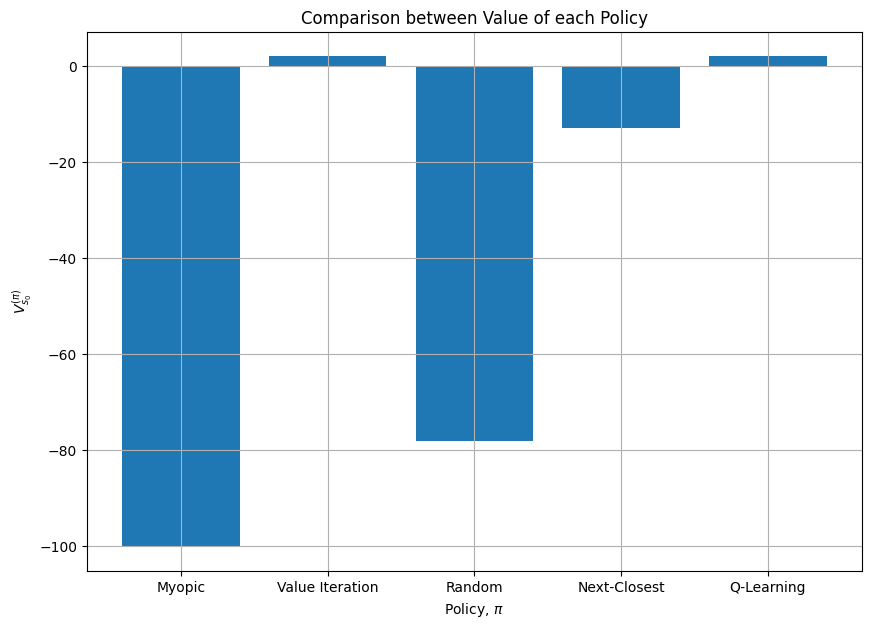

In [37]:
Values =    [sum(R_myopic), sum(R_value),      sum(R_rand), sum(R_next),     sum(R_Q)]
Policies = ['Myopic',      'Value Iteration',  'Random',    'Next-Closest', 'Q-Learning']

fig, ax = plt.subplots(figsize=(10,7))
plt.bar(Policies, Values)
plt.title('Comparison between Value of each Policy')
plt.xlabel(r'Policy, $\pi$')
plt.ylabel(r'$V_{s_0}^{(\pi)}$')
plt.grid()

plt.show()

Feel free to experiment how these results would change if the rewards or dynamics were different.